In [1]:
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt

from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

from tsdart.utils import set_random_seed
from tsdart.loss import Prototypes
from tsdart.model import TSDART, TSDARTLayer, TSDARTEstimator
from tsdart.dataprocessing import Preprocessing

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('cuda is available')
else:
    device = torch.device('cpu')
    print('cpu')

cpu


### Quadruple-well potential

Text(0, 0.5, 'y')

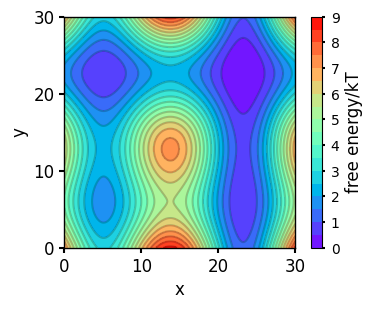

In [3]:
# quadruple-well potential
# See "RPnet: a reverse-projection-based neural network for coarse-graining metastable conformational states for protein dynamics" for simulation details.
# The temperature is specified as 0.4

V = lambda x,y: 1/8*(np.cos(x/6)-3*np.sin(x/3)+5)*(np.cos(y/6)-np.sin(y/3)+3)

fig,ax = plt.subplots(1,1,figsize=(4,3))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)
ax.set_aspect('equal')

x = np.arange(0,30+0.1,0.1)
y = np.arange(0,30+0.1,0.1)
xx,yy = np.meshgrid(x,y)
z = V(xx.ravel(),yy.ravel()).reshape(len(y),-1)
z = z - z.min()
z = z*1/0.4 # temperature is 0.4.
z = np.ma.masked_greater(z,10) 

c = ax.contourf(x,y,z,cmap='rainbow',levels=20,zorder=1)
ax.contour(x,y,z,levels=20,zorder=1,colors='black',alpha=0.2)
cb = fig.colorbar(c)
#ax.grid(True)
ax.tick_params(axis="both",labelsize=12,direction='out',length=3.5,width=1.5)
cb.ax.tick_params(labelsize=10,length=2.5,width=1.5)
cb.set_label('free energy/kT',fontsize=12)

ax.set_xlim(0,30)
ax.set_ylim(0,30)

ax.set_xticks([0,10,20,30])
ax.set_yticks([0,10,20,30])

ax.set_xlabel('x',fontsize=12)
ax.set_ylabel('y',fontsize=12)

### Create dataset

In [4]:
data = np.load('../data/quadruple-well.npy')

pre = Preprocessing(dtype=np.float32)
dataset = pre.create_dataset(lag_time=10,data=data)

### 2 states model

In [5]:
set_random_seed(1)

val = int(len(dataset)*0.10)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset)-val, val])

loader_train = DataLoader(train_data, batch_size=1000, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

lobe = TSDARTLayer([2,20,20,20,10,2],n_states=2)
lobe = lobe.to(device=device)

tsdart = TSDART(lobe = lobe, learning_rate = 1e-3, device = device, mode = 'regularize', beta=0.01, feat_dim=2, n_states=2, pretrain=10)
tsdart_model = tsdart.fit(loader_train, n_epochs=20, validation_loader=loader_val).fetch_model()

In [6]:
tsdart_estimator = TSDARTEstimator(tsdart_model)
ood_scores = tsdart_estimator.fit(data).ood_scores

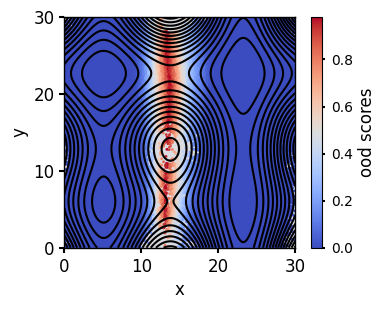

In [7]:
# quadruple-well potential
V = lambda x,y: 1/8*(np.cos(x/6)-3*np.sin(x/3)+5)*(np.cos(y/6)-np.sin(y/3)+3)

fig,ax = plt.subplots(1,1,figsize=(4,3))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)
ax.set_aspect('equal')

x = np.arange(0,30+0.1,0.1)
y = np.arange(0,30+0.1,0.1)
xx,yy = np.meshgrid(x,y)
z = V(xx.ravel(),yy.ravel()).reshape(len(y),-1)
z = z - z.min()
z = z*1/0.4 # temperature is 0.4.
z = np.ma.masked_greater(z,10)

c = ax.scatter(data[:,0],data[:,1],c=ood_scores,cmap='coolwarm',s=1,alpha=1)
cb = fig.colorbar(c)
cb.ax.tick_params(labelsize=10,length=2.5,width=1.5)
cb.set_label('ood scores',fontsize=12)

ax.contour(x,y,z,levels=20,zorder=1,colors='black',alpha=1)

ax.tick_params(axis="both",labelsize=12,direction='out',length=3.5,width=1.5)

ax.set_xlim(0,30)
ax.set_ylim(0,30)

ax.set_xticks([0,10,20,30])
ax.set_yticks([0,10,20,30])

ax.set_xlabel('x',fontsize=12)
ax.set_ylabel('y',fontsize=12)

r=0.1
g=0.1
b=0.2
ax.patch.set_facecolor((r,g,b,.15))

In [8]:
features = tsdart_model.transform(data,return_type='hypersphere_embs')
state_centers = tsdart_estimator.fit(data).state_centers

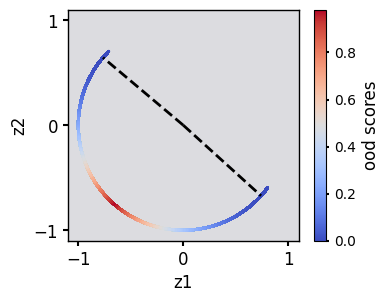

In [9]:
fig,ax = plt.subplots(1,1,figsize=(4,3))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)
ax.set_aspect('equal')

c = ax.scatter(features[:,0],features[:,1],c=ood_scores,cmap='coolwarm',s=1,alpha=1)
cb = fig.colorbar(c)
cb.ax.tick_params(labelsize=10,length=2.5,width=1.5)
cb.set_label('ood scores',fontsize=12)

ax.plot([0,state_centers[0,0]],[0,state_centers[0,1]],linewidth=2,color='black',linestyle='--')
ax.plot([0,state_centers[1,0]],[0,state_centers[1,1]],linewidth=2,color='black',linestyle='--')

ax.tick_params(axis="both",labelsize=12,direction='out',length=3.5,width=1.5)

ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)

ax.set_xticks([-1,0,1])
ax.set_yticks([-1,0,1])

ax.set_xlabel('z1',fontsize=12)
ax.set_ylabel('z2',fontsize=12)

r=0.1
g=0.1
b=0.2
ax.patch.set_facecolor((r,g,b,.15))

### 3 states model

In [10]:
set_random_seed(1)

val = int(len(dataset)*0.10)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset)-val, val])

loader_train = DataLoader(train_data, batch_size=1000, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

lobe = TSDARTLayer([2,20,20,20,10,2],n_states=3)
lobe = lobe.to(device=device)

tsdart = TSDART(lobe = lobe, learning_rate = 1e-3, device = device, mode = 'regularize', beta=0.01, feat_dim=2, n_states=3, pretrain=10)
tsdart_model = tsdart.fit(loader_train, n_epochs=20, validation_loader=loader_val).fetch_model()

In [11]:
tsdart_estimator = TSDARTEstimator(tsdart_model)
ood_scores = tsdart_estimator.fit(data).ood_scores

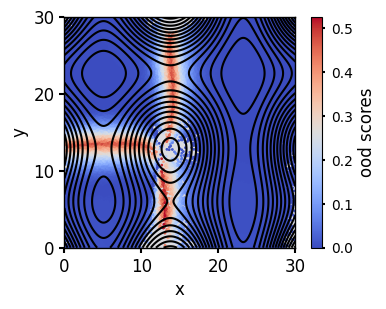

In [12]:
# quadruple-well potential
V = lambda x,y: 1/8*(np.cos(x/6)-3*np.sin(x/3)+5)*(np.cos(y/6)-np.sin(y/3)+3)

fig,ax = plt.subplots(1,1,figsize=(4,3))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)
ax.set_aspect('equal')

x = np.arange(0,30+0.1,0.1)
y = np.arange(0,30+0.1,0.1)
xx,yy = np.meshgrid(x,y)
z = V(xx.ravel(),yy.ravel()).reshape(len(y),-1)
z = z - z.min()
z = z*1/0.4 # temperature is 0.4.
z = np.ma.masked_greater(z,10)

c = ax.scatter(data[:,0],data[:,1],c=ood_scores,cmap='coolwarm',s=1,alpha=1)
cb = fig.colorbar(c)
cb.ax.tick_params(labelsize=10,length=2.5,width=1.5)
cb.set_label('ood scores',fontsize=12)

ax.contour(x,y,z,levels=20,zorder=1,colors='black',alpha=1)

ax.tick_params(axis="both",labelsize=12,direction='out',length=3.5,width=1.5)

ax.set_xlim(0,30)
ax.set_ylim(0,30)

ax.set_xticks([0,10,20,30])
ax.set_yticks([0,10,20,30])

ax.set_xlabel('x',fontsize=12)
ax.set_ylabel('y',fontsize=12)

r=0.1
g=0.1
b=0.2
ax.patch.set_facecolor((r,g,b,.15))

In [13]:
features = tsdart_model.transform(data,return_type='hypersphere_embs')
state_centers = tsdart_estimator.fit(data).state_centers

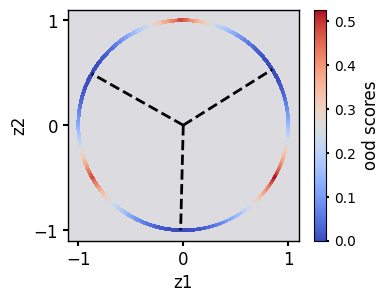

In [14]:
fig,ax = plt.subplots(1,1,figsize=(4,3))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)
ax.set_aspect('equal')

c = ax.scatter(features[:,0],features[:,1],c=ood_scores,cmap='coolwarm',s=1,alpha=1)
cb = fig.colorbar(c)
cb.ax.tick_params(labelsize=10,length=2.5,width=1.5)
cb.set_label('ood scores',fontsize=12)

ax.plot([0,state_centers[0,0]],[0,state_centers[0,1]],linewidth=2,color='black',linestyle='--')
ax.plot([0,state_centers[1,0]],[0,state_centers[1,1]],linewidth=2,color='black',linestyle='--')
ax.plot([0,state_centers[2,0]],[0,state_centers[2,1]],linewidth=2,color='black',linestyle='--')

ax.tick_params(axis="both",labelsize=12,direction='out',length=3.5,width=1.5)

ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)

ax.set_xticks([-1,0,1])
ax.set_yticks([-1,0,1])

ax.set_xlabel('z1',fontsize=12)
ax.set_ylabel('z2',fontsize=12)

r=0.1
g=0.1
b=0.2
ax.patch.set_facecolor((r,g,b,.15))

### 4 states model

In [15]:
set_random_seed(1)

val = int(len(dataset)*0.10)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset)-val, val])

loader_train = DataLoader(train_data, batch_size=1000, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

lobe = TSDARTLayer([2,20,20,20,10,3],n_states=4)
lobe = lobe.to(device=device)

tsdart = TSDART(lobe = lobe, learning_rate = 1e-3, device = device, mode = 'regularize', beta=0.01, feat_dim=3, n_states=4, pretrain=10)
tsdart_model = tsdart.fit(loader_train, n_epochs=20, validation_loader=loader_val).fetch_model()

In [16]:
tsdart_estimator = TSDARTEstimator(tsdart_model)
ood_scores = tsdart_estimator.fit(data).ood_scores

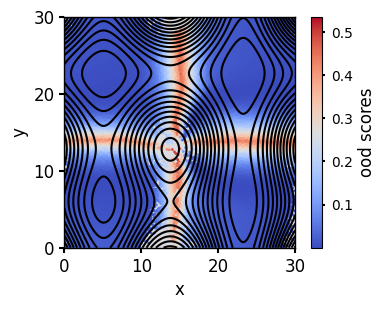

In [17]:
# quadruple-well potential
V = lambda x,y: 1/8*(np.cos(x/6)-3*np.sin(x/3)+5)*(np.cos(y/6)-np.sin(y/3)+3)

fig,ax = plt.subplots(1,1,figsize=(4,3))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)
ax.set_aspect('equal')

x = np.arange(0,30+0.1,0.1)
y = np.arange(0,30+0.1,0.1)
xx,yy = np.meshgrid(x,y)
z = V(xx.ravel(),yy.ravel()).reshape(len(y),-1)
z = z - z.min()
z = z*1/0.4 # temperature is 0.4.
z = np.ma.masked_greater(z,10)

c = ax.scatter(data[:,0],data[:,1],c=ood_scores,cmap='coolwarm',s=1,alpha=1)
cb = fig.colorbar(c)
cb.ax.tick_params(labelsize=10,length=2.5,width=1.5)
cb.set_label('ood scores',fontsize=12)

ax.contour(x,y,z,levels=20,zorder=1,colors='black',alpha=1)

ax.tick_params(axis="both",labelsize=12,direction='out',length=3.5,width=1.5)

ax.set_xlim(0,30)
ax.set_ylim(0,30)

ax.set_xticks([0,10,20,30])
ax.set_yticks([0,10,20,30])

ax.set_xlabel('x',fontsize=12)
ax.set_ylabel('y',fontsize=12)

r=0.1
g=0.1
b=0.2
ax.patch.set_facecolor((r,g,b,.15))

In [18]:
features = tsdart_model.transform(data,return_type='hypersphere_embs')
state_centers = tsdart_estimator.fit(data).state_centers

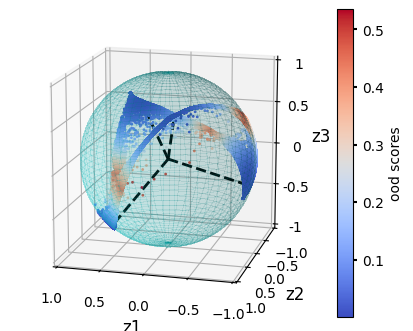

In [21]:
r = 1
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
x = r*sin(phi)*cos(theta)
y = r*sin(phi)*sin(theta)
z = r*cos(phi)

plt.rcParams['figure.figsize'] = (5,4)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(
   x, y, z,  rstride=2, cstride=2, color='c', alpha=0.1, linewidth=100,antialiased=False)

ax.plot([0,state_centers[0,0]],[0,state_centers[0,1]],[0,state_centers[0,2]],linewidth=2,color='black',linestyle='--')
ax.plot([0,state_centers[1,0]],[0,state_centers[1,1]],[0,state_centers[1,2]],linewidth=2,color='black',linestyle='--')
ax.plot([0,state_centers[2,0]],[0,state_centers[2,1]],[0,state_centers[2,2]],linewidth=2,color='black',linestyle='--')
ax.plot([0,state_centers[3,0]],[0,state_centers[3,1]],[0,state_centers[3,2]],linewidth=2,color='black',linestyle='--')

c = ax.scatter(features[:,0],features[:,1],features[:,2],c=ood_scores[:],s=1,alpha=1,cmap='coolwarm')

cb = fig.colorbar(c)
cb.ax.tick_params(labelsize=10,length=3,width=1.5)
cb.set_label('ood scores',fontsize=10)

ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
ax.set_xticks([-1,-0.5,0,0.5,1])
ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_zticks([-1,-0.5,0,0.5,1],[-1,-0.5,0,0.5,1])
ax.set_aspect("equal")
ax.tick_params(axis="both",labelsize=10,direction='out',length=7.5,width=2.5)

ax.set_xlabel('z1',fontsize=12)
ax.set_ylabel('z2',fontsize=12)
ax.set_zlabel('z3',fontsize=12)

ax.view_init(elev=15., azim=105)